# cs109a Final Project Milestone 3: EDA

In [ ]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [53]:
# helper functions

def visualize_missingness(df, figsize=(6, 7)):
    # calculate missing data percentages
    missing_data_percentage = (df.isnull().sum() / len(df)) * 100
    # sort by percentage
    missing_data_percentage = missing_data_percentage.sort_values(ascending=True)
    # visualize using horizontal barplot
    plt.figure(figsize=figsize)
    missing_data_percentage.plot(kind='barh')
    plt.title('Percentage of Missing Data by Column')
    plt.xlabel('Percentage Missing (%)')
    plt.ylabel('Columns')
    plt.show()

def visualize_class_imbalance(df, target_col, figsize=(5, 2)):
    # Visualize class imbalance
    plt.figure(figsize=figsize)
    df[target_col].value_counts().plot(kind='barh')
    plt.title('Class Distribution')
    plt.ylabel('Class Label')
    plt.xlabel('Number of Samples')
    plt.show()

def missing_values_table(df):
    # count the missing values for each column
    missing_values = df.isnull().sum()
    # calculate the percentage of missing values
    missing_percentage = (100 * df.isnull().sum() / len(df))
    # create a table with the results
    missing_values_table = pd.concat([missing_values, missing_percentage], axis=1)
    # rename the columns
    missing_values_table_columns = missing_values_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # sort the table by percentage of missing in descending order
    missing_values_table_columns = missing_values_table_columns[
        missing_values_table_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    # print a summary
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_values_table_columns.shape[0]) +
            " columns that have missing values.")
    # return the dataframe with missing info
    return missing_values_table_columns
    
def handle_missing_data(df):
    # keep track of the original columns
    original_columns = df.columns.tolist()
    # create dummy columns only for columns with missing data
    for col in original_columns:
        if df[col].isna().any(): 
            df[col + "_is_missing"] = df[col].isna().astype(int)
    # define imputers
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    # impute median values for numeric columns and most frequent value for non-numeric columns
    for col in original_columns:
        if df[col].dtype in [np.float64, np.int64]: 
            df[col] = numeric_imputer.fit_transform(df[[col]]).flatten()
        else:  
            df[col] = categorical_imputer.fit_transform(df[[col]]).flatten() 
    return df

def scale_data(df, columns_to_scale):
    scaler = StandardScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

In [54]:
# load data
df = pd.read_csv('../data/diabetic_data.csv', na_values='?')

# examine first 5 rows of dataframe
print(f'Shape of diabetic data: {df.shape}')
display(df.head())

Shape of diabetic data: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


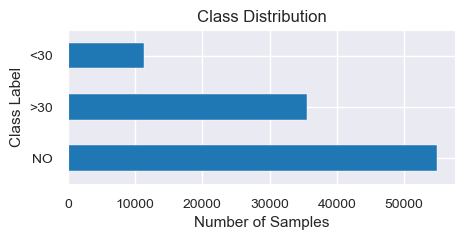

In [41]:
# class imbalance
visualize_class_imbalance(df, target_col='readmitted')

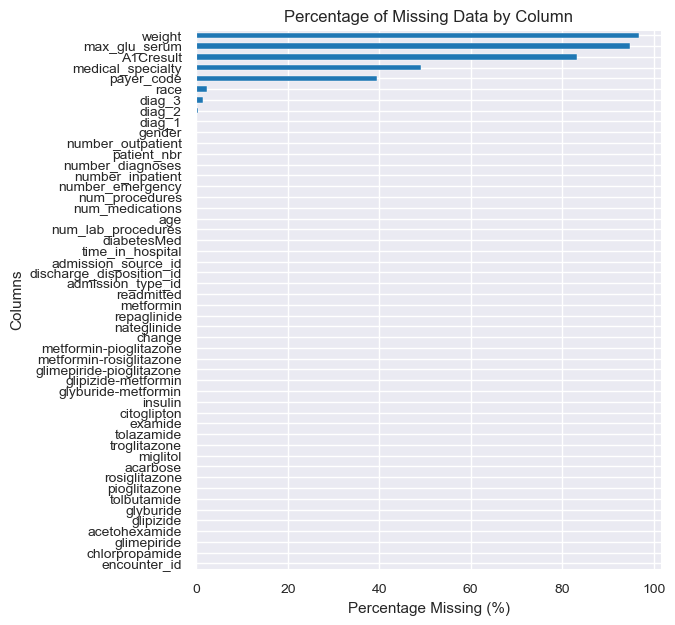

In [42]:
# visualize missingness
visualize_missingness(df)

In [43]:
# missing values table
missing_values_table(df)

Your selected dataframe has 50 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
weight,98569,96.9
max_glu_serum,96420,94.7
A1Cresult,84748,83.3
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0


In [55]:
# deal with missing data
df_imp = handle_missing_data(df)

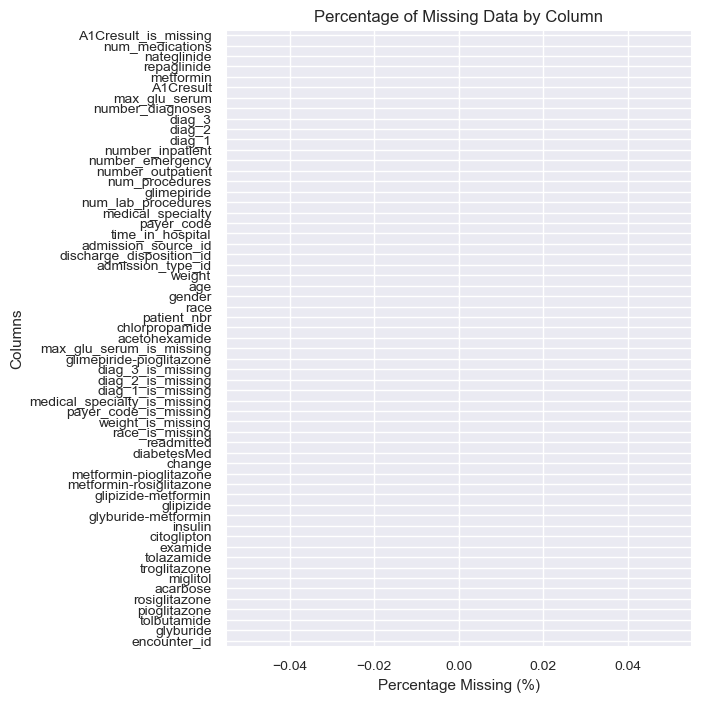

In [57]:
# look at imputed data
visualize_missingness(df_imp, figsize=(6, 8))

In [58]:
# standardize data
df_std = scale_data(df_imp, ['time_in_hospital'])
df_std.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,...,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,race_is_missing,weight_is_missing,payer_code_is_missing,medical_specialty_is_missing,diag_1_is_missing,diag_2_is_missing,diag_3_is_missing,max_glu_serum_is_missing,A1Cresult_is_missing
0,2.278e+06,8.222e+06,Caucasian,Female,[0-10),[75-100),6.0,25.0,1.0,-1.138,MC,Pediatrics-Endocrinology,41.0,0.0,1.0,0.0,0.0,0.0,250.83,276,250,1.0,Norm,>8,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,1,1,0,0,1,1,1,1
1,1.492e+05,5.563e+07,Caucasian,Female,[10-20),[75-100),1.0,1.0,7.0,-0.468,MC,InternalMedicine,59.0,0.0,18.0,0.0,0.0,0.0,276,250.01,255,9.0,Norm,>8,No,...,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,0,1,1,1,0,0,0,1,1
2,6.441e+04,8.605e+07,AfricanAmerican,Female,[20-30),[75-100),1.0,1.0,7.0,-0.803,MC,InternalMedicine,11.0,5.0,13.0,2.0,0.0,1.0,648,250,V27,6.0,Norm,>8,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0,1,1,1,0,0,0,1,1
3,5.004e+05,8.244e+07,Caucasian,Male,[30-40),[75-100),1.0,1.0,7.0,-0.803,MC,InternalMedicine,44.0,1.0,16.0,0.0,0.0,0.0,8,250.43,403,7.0,Norm,>8,No,...,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0,1,1,1,0,0,0,1,1
4,1.668e+04,4.252e+07,Caucasian,Male,[40-50),[75-100),1.0,1.0,7.0,-1.138,MC,InternalMedicine,51.0,0.0,8.0,0.0,0.0,0.0,197,157,250,5.0,Norm,>8,No,...,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,1,1,1,0,0,0,1,1
